# Mô phỏng dữ liệu cho kết quả dự kiến

**BS. Lê Ngọc Khả Nhi**

Bài này minh họa cho ý tưởng có thể dùng phương pháp mô phỏng để tạo ra dữ liệu, sau đó làm phân tích để tạo ra kết quả y như thật, dùng trình bày trong chương « Kết quả dự kiến » trong đề cương nghiên cứu.

Tình huống giả định là một nghiên cứu đoàn hệ hồi cứu về kết cục sản khoa của thai nhi ngôi mông. Một trong các **mục tiêu** là: Khảo sát liên hệ giữa loại ngôi mông và nguy cơ thất bại của sinh thường

**Kế hoạch phân tích dự kiến :**

1) Ước lượng nguy cơ sinh thường thất bại độc lập với thời gian của loại ngôi mông thiếu bằng mô hình hồi quy logistic đơn biến.

2) So sánh đặc điểm của xác suất tiếp tục tiến trình sinh thường giữa 2 nhóm Ngôi mông hoàn toàn và ngôi mông thiếu bằng phương pháp ước lượng Kaplan-Meier và kiểm định Log-rank

3) Ước lượng nguy cơ sinh thường thất bại ở ngôi mông thiếu so với ngôi mông hoàn toàn bằng mô hình hồi quy Cox-PH

In [1]:
warning_status = "ignore"

import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)

from typing import Dict

from dataclasses import dataclass, field

import pandas as pd
import numpy as np

from patsy import dmatrices
import statsmodels.api as sm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Thư viện lifelines

## Non parametric Estimators
from lifelines import KaplanMeierFitter

## Semi-parametric Regression model
from lifelines import CoxPHFitter

## Life-table
from lifelines.plotting import add_at_risk_counts

## Log-rank test
from lifelines.statistics import logrank_test

**Tiến hành mô phỏng dữ liệu :**

Giả định ta có một mẫu quan sát với kích thước n = 350 thai phụ, tỉ lệ ngôi mông hoàn toàn và ngôi mông thiếu là cân bằng (xác suất = 0.5). Ta có thể mô phỏng dữ liệu cho biến nhị phân X chỉ loại ngôi mông bằng phân phối binomial với p=0.5, n= 400

Tiếp theo, ta mô phỏng thời gian diễn tiến đến khi phát sinh biến cố sinh thường thất bại (chuyển sang phẫu thuật lấy thai) (event = 1), hoặc sinh thường tiếp tục diễn ra (event = 0) theo quy tắc như sau :

Thời gian diễn tiến sinh thường (survival_time) là một biến ngẫu nhiên có phân phối logarit normal, với 2 tham số mu và sigma

Tham số mu được xác định bằng 1 mô hình tuyến tính :

$$\mu \text{~} Intercept + b_{1}.X$$

Intercept và b_1 có phân phối chuẩn với mean và sd

Tham số sigma là hằng số và luôn >0 (hàm exponential sẽ được dùng) 

$$log(\sigma) \text{~} b_{0}$$

b0 có phân phối chuẩn với mean và sd

Biến cố sinh thường thất bại (event = 1) được xác định bằng 2 quy luật : đầu tiên, nó chỉ phát sinh trong khoảng thời gian 3 giờ cho đến 30h, thứ hai, tỷ lệ thất bại trong mẫu khảo sát là 15% (một sự kiện ngẫu nhiên với xác suất = 0.15).

Tất cả những trường hợp còn lại xem như censored (sinh thường thành công, không có thất bại)

In [2]:
# Simulate mu
def sim_mu(x, mu_intercept, mu_slope, mu_intercept_sd, mu_slope_sd):

    mu_intercept = np.random.normal(mu_intercept, mu_intercept_sd)
    mu_slope = np.random.normal(mu_slope, mu_slope_sd)
    mu = mu_intercept + mu_slope * x
    return(mu)

# Simulate sigma
def sim_sigma(sigma_intercept, sigma_intercept_sd):

    sigma = np.exp(np.random.normal(sigma_intercept, sigma_intercept_sd))
    return(sigma)

# Simulate survival time
def sim_survival_time(mu, sigma):

    survival_time = np.random.lognormal(mu, sigma)
    
    return(survival_time)

#Simulate event or censoring
def sim_event_censoring(event_time: np.array, start_t: float, max_time: float):

    event = np.where((event_time >= start_t) & (event_time <= max_time), 1, 0)

    return (event)

def simulate_data(df, mu_intercept, mu_slope, mu_intercept_sd, mu_slope_sd, sigma_intercept, sigma_intercept_sd, start_t, max_time, event_rate):

    df['mu'] = sim_mu(df['x'], mu_intercept, mu_slope, mu_intercept_sd, mu_slope_sd)
    df['sigma'] = sim_sigma(sigma_intercept, sigma_intercept_sd)
    df['survival_time'] = sim_survival_time(df['mu'], df['sigma'])

    # Simulate event or censoring
    df['event'] = sim_event_censoring(df['survival_time'], start_t, max_time)
    
    # Add random censoring status to get event rate = 0.2
    for i in range(len(df)):
        if df['event'][i] == 1:
            if np.random.uniform(0, 1) >= event_rate:
                df['event'][i] = 0
    
    return(df)

In [6]:
# Set seed
np.random.seed(123)

# Simulate data
n = 400

# Simulate x
x = np.random.binomial(1, 0.5, n)

# Create dataframe
df = pd.DataFrame({'x': x})

df = simulate_data(df = df, 
              mu_intercept = 3.37,
              mu_slope = -0.16,
              mu_intercept_sd = 0.15, 
              mu_slope_sd = 0.15,
              sigma_intercept = -0.2, 
              sigma_intercept_sd = 0.1, 
              start_t = 3.,
              max_time = 30.,
              event_rate = 0.15)

In [5]:
mod_df = df[['survival_time',
             'event']].copy()

mod_df['Incomplete'] = (df['x'] == 1)

mod_df

,survival_time,event,Incomplete
0,25.922327,0,True
1,19.884620,0,False
2,100.231826,0,False
3,11.915278,0,True
4,17.189274,1,True
...,...,...,...
395,16.424327,0,False
396,98.607295,0,False
397,30.617513,0,False
398,40.728567,0,False


**Hồi quy logistic**

In [3]:
@dataclass
class Logistic_reg:

    data: pd.DataFrame = field(init = True)
    formula: str = field(init = True)
    _mod_df: Dict[str, pd.DataFrame] = field(init = False)

    def __post_init__(self):

        y, X = dmatrices(self.formula, self.data, return_type='dataframe')

        self._mod_df = {'y': y, 'X': X}
        self._model = sm.Logit(y, X).fit()
        
    def summary(self):

        model = self._model
        
        tbl_1 = model.summary().tables[0]
        
        tbl_2 = model.summary2().tables[1]

        params = model.params
        conf = model.conf_int()
        conf['Odds Ratio'] = params
        conf.columns = ['OR_LL', 'OR_UL', 'Odds Ratio']
        odds = pd.DataFrame(np.exp(conf))

        odds['pvalues'] = model.pvalues
        odds['significant'] = ['significant' if pval <= 0.05 else 'not significant' for pval in model.pvalues]
        odds = odds[['Odds Ratio','OR_LL','OR_UL', 'pvalues', 'significant']]

        self._odds = odds
        
        print(tbl_1)
        print(tbl_2)
        print(odds)
        
    def plot_OR(self):
        
        odds = self._odds.iloc[1:,:]
        
        fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)

        for idx, row in odds.iloc[::-1].iterrows():
            ci = [[row['Odds Ratio'] - row[::-1]['OR_LL']], [row['OR_UL'] - row['Odds Ratio']]]
            if row['significant'] == 'significant':
                plt.errorbar(x=[row['Odds Ratio']], 
                             y=[row.name], 
                             xerr=ci,
                             ecolor='tab:red', 
                             capsize=3, 
                             linestyle='None', 
                             linewidth=1, 
                             marker="o", 
                             markersize=5,
                             mfc="tab:red", 
                             mec="tab:red")
            else:
                plt.errorbar(x=[row['Odds Ratio']], 
                             y=[row.name], 
                             xerr=ci,
                             ecolor='tab:gray', 
                             capsize=3, 
                             linestyle='None', 
                             linewidth=1, 
                             marker="o", 
                             markersize=5, 
                             mfc="tab:gray", 
                             mec="tab:gray")

        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        plt.tick_params(axis='both', which='major', labelsize=8)
        plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
        # plt.xlim([0.5,2.])
        plt.tight_layout()
        plt.show()

Optimization terminated successfully.
         Current function value: 0.435490
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  event   No. Observations:                  400
Model:                          Logit   Df Residuals:                      398
Method:                           MLE   Df Model:                            1
Date:                Tue, 17 Jan 2023   Pseudo R-squ.:               2.538e-05
Time:                        11:07:25   Log-Likelihood:                -174.20
converged:                       True   LL-Null:                       -174.20
Covariance Type:            nonrobust   LLR p-value:                    0.9251
                       Coef.  Std.Err.         z         P>|z|    [0.025  \
Intercept          -1.664163  0.192788 -8.632093  6.023922e-18 -2.042020   
Incomplete[T.True] -0.025814  0.274550 -0.094023  9.250910e-01 -0.563922   

                      0.975]  
Interc

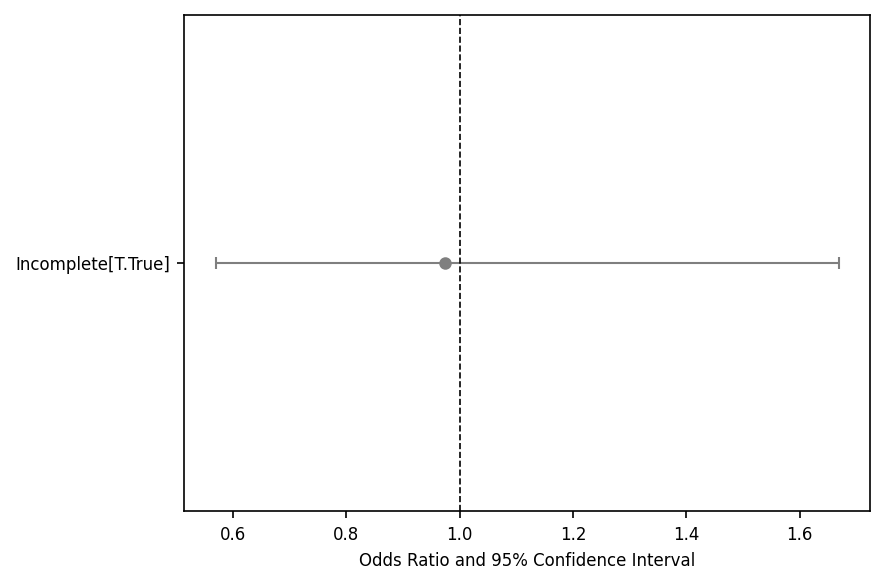

In [7]:
log_mod = Logistic_reg(data = mod_df, 
                           formula = "event ~ Incomplete")
    
log_mod.summary()
log_mod.plot_OR()

**Ước lượng Kaplan Meier và log-rank test**

In [8]:
# Survival analysis

def estimate(T: pd.Series,
            E: pd.Series,
            I: pd.Series
            ):
    
    fig = plt.figure(figsize=(7,6))
    ax = plt.subplot(111)
    
    est_a = KaplanMeierFitter()
    est_a.fit(T[I],E[I], label='Kg hoàn toàn')
    est_a.plot_survival_function(ax = ax, color = '#0e80cc')
    est_b = KaplanMeierFitter()
    est_b.fit(T[~I],E[~I], label='Hoàn toàn')
    est_b.plot_survival_function(ax = ax, color = '#cc0e3b')
    plt.ylabel("Xác suất tiếp diễn sinh thường s(t)")
    
    plt.xlim([-0.01,30.])
    plt.xlabel('Thời gian theo dõi (giờ)')
        
    add_at_risk_counts(est_a, est_b, ax=ax, fig=fig)
    plt.tight_layout()
    plt.show()
    
    return

def log_rank_test(T: pd.Series,
            E: pd.Series,
            I: pd.Series,):
    
    results = logrank_test(T[I], T[~I], E[I], E[~I])
    
    return results

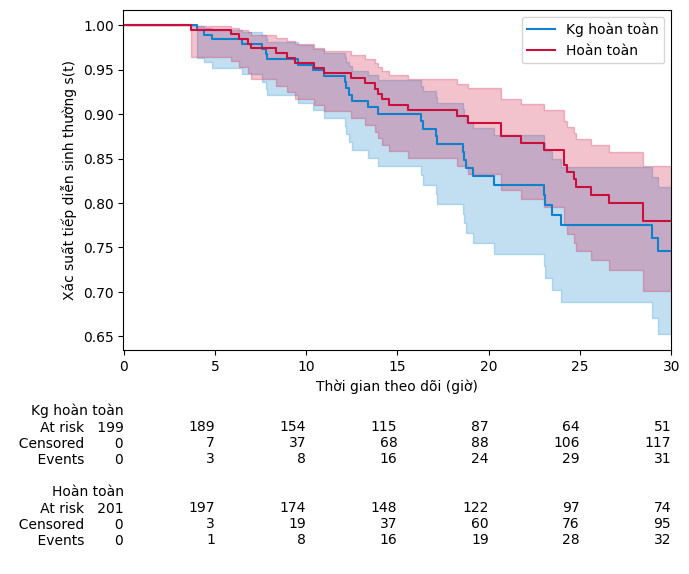

In [9]:
T = df['survival_time'].copy()
E = df['event'].copy()
I = (df['x'] == 1)

estimate(T,E,I)

In [10]:
log_rank_test(T,E,I)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.70 0.40      1.31

**Mô hình hồi quy Cox-PH**

In [13]:
mod = CoxPHFitter()

mod.fit(mod_df,
        duration_col= 'survival_time', 
        event_col='event')

mod.print_summary()

<lifelines.CoxPHFitter: fitted with 400 total observations, 337 right-censored observations>
             duration col = 'survival_time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 400
number of events observed = 63
   partial log-likelihood = -347.08
         time fit was run = 2023-01-17 10:10:27 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
Incomplete   0.21       1.23       0.25            -0.28             0.71                 0.75                 2.03

              z    p   -log2(p)
covariate                      
Incomplete 0.83 0.40       1.31
---
Concordance = 0.53
Partial AIC = 696.15
log-likelihood ratio test = 0.69 on 1 df
-log2(p) of ll-ratio test = 1.30

In [21]:
def plot_marginal_effect(mod = None, 
                         func: 'str' = 'hazard_function', 
                         cov: str = None, 
                         values = None):
    
    y_labs = {'cumulative_hazard': "Nguy cơ thất bại tích lũy H(t)",
              'survival_function': "Xác suất tiếp diễn sinh thường S(t)"
             }
    
    plt.figure(figsize=(8,5))
    ax = plt.subplot(111)

    mod.plot_partial_effects_on_outcome(covariates=cov, 
                                        values=values,
                                        y=func,
                                        cmap='coolwarm', 
                                        ax = ax)
    plt.xlim([-0.01,30.])
    plt.xlabel('Thời gian theo dõi (giờ)')
    plt.ylabel(y_labs[func])

    plt.show()

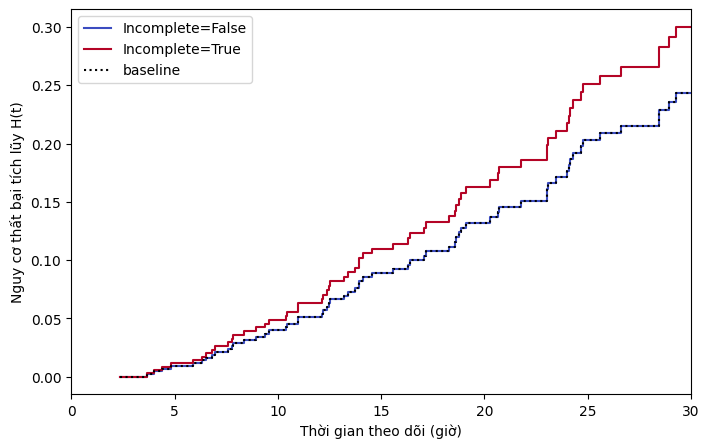

In [22]:
plot_marginal_effect(mod = mod,
                    func = "cumulative_hazard",
                    cov = 'Incomplete',
                    values = [False, True])

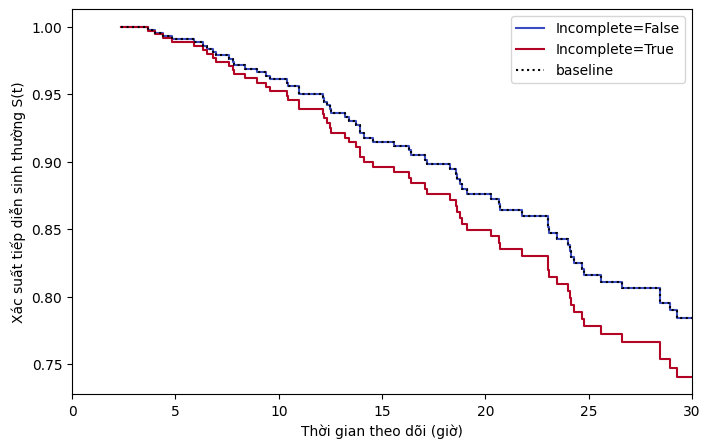

In [23]:
plot_marginal_effect(mod = mod,
                    func = "survival_function",
                    cov = 'Incomplete',
                    values = [False, True])